In [2]:
# force reload
%load_ext autoreload
%autoreload 2


import utils
import numpy as np
import os
import matplotlib.pyplot as plt
import random
import imageio.v2 as imageio
import io
import dataset


In [19]:
# Load data
data = utils.load_zipped_pickle("data/train.pkl")
test_data = utils.load_zipped_pickle("data/test.pkl")

# Preprocess to get Video objects
videos = utils.preprocess_train_data(data)
test_videos = utils.preprocess_test_data(test_data)

Video(name=D47OR19ANJ, video=(112, 112, 334), box=(112, 112), label=(112, 112, 334), labeled frames=[15, 59, 143], total frames=334, label_type=amateur)
Video(name=IMNKTJV3OI, video=(112, 112, 177), box=(112, 112), label=(112, 112, 177), labeled frames=[2, 47, 79], total frames=177, label_type=amateur)
Video(name=YSCCEISFRH, video=(112, 112, 195), box=(112, 112), label=(112, 112, 195), labeled frames=[18, 83, 131], total frames=195, label_type=amateur)
Video(name=VI47TJR3OQ, video=(112, 112, 181), box=(112, 112), label=(112, 112, 181), labeled frames=[19, 118, 180], total frames=181, label_type=amateur)
Video(name=7V9NY3JFPX, video=(112, 112, 211), box=(112, 112), label=(112, 112, 211), labeled frames=[36, 76, 134], total frames=211, label_type=amateur)
Video(name=K3AM1YOI38, video=(112, 112, 209), box=(112, 112), label=(112, 112, 209), labeled frames=[22, 51, 129], total frames=209, label_type=amateur)
Video(name=BBB0U709D2, video=(112, 112, 129), box=(112, 112), label=(112, 112, 129)

# Exploration

Save the first video as a black and white GIF.

In [10]:
# Get first video
first_video = videos[0]

print(f"Loaded video: {first_video.name}")
print(f"Video shape: {first_video.video.shape}")
if first_video.box is not None:
    print(f"Box shape: {first_video.box.shape}")
else:
    print("Box is None")

# Prepare data for save_gif
# video.video is (H, W, T) -> need (T, H, W)
frames = first_video.video.transpose(2, 0, 1)

# Handle box
if first_video.box is None:
    boxes = [None] * len(frames)
elif first_video.box.ndim == 3:
    boxes = first_video.box.transpose(2, 0, 1)
else:
    # Assume 2D (H, W) shared across frames
    boxes = [first_video.box] * len(frames)

# Handle label
if first_video.label is None:
    masks = [None] * len(frames)
else:
    # label is expected to be 3D based on video.py
    masks = first_video.label.transpose(2, 0, 1)

# Save gif
utils.save_gif(frames, boxes, masks, "first_video_bw")
print("GIF saved to plots/first_video_bw.gif")

Loaded video: D47OR19ANJ
Video shape: (112, 112, 334)
Box shape: (112, 112)
GIF saved to plots/first_video_bw.gif


Check that all label are False in not labeled frames

In [ ]:
for video in videos:
    for i in range(video.total_frames):
        
        # unpack frame
        frame, box, label = video[i]
    
        if not video.is_labeled(i):
            assert label.sum() == 0
        
        else:
            assert label.sum() > 0

print("All frames marked as labeled are labeled and all other frames are empty masks")
            


All frames marked as labeled are labeled and all other frames are empty masks


: 

View number of total unlabeled and labeled frames

Counting frames...
Plotting results...
Plot saved to plots/labeled_vs_unlabeled_frames.png


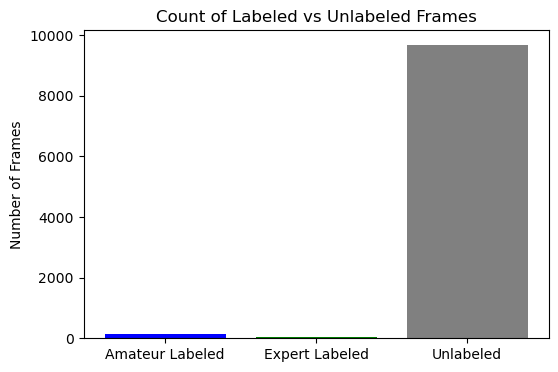

Amateur Labeled: 138
Expert Labeled: 57
Unlabeled: 9674


In [4]:
amateur_labeled_count = 0
expert_labeled_count = 0
unlabeled_count = 0

print("Counting frames...")
for video in videos:
    labeled_frames = len(video.frames)
    unlabeled = video.total_frames - labeled_frames
    
    if video.label_type and 'amateur' in video.label_type.lower():
        amateur_labeled_count += labeled_frames
    elif video.label_type and 'expert' in video.label_type.lower():
        expert_labeled_count += labeled_frames
    else:
        print(f"Unknown or missing label type: {video.label_type}")
        # Treat as unlabeled or separate category? For now just log it.
        
    unlabeled_count += unlabeled

labels = ['Amateur Labeled', 'Expert Labeled', 'Unlabeled']
counts = [amateur_labeled_count, expert_labeled_count, unlabeled_count]

print("Plotting results...")
plt.figure(figsize=(6, 4))
plt.bar(labels, counts, color=['blue', 'green', 'gray'])
plt.title('Count of Labeled vs Unlabeled Frames')
plt.ylabel('Number of Frames')

# Save the plot
if not os.path.exists("plots"):
    os.makedirs("plots")
plt.savefig("plots/labeled_vs_unlabeled_frames.png")
print("Plot saved to plots/labeled_vs_unlabeled_frames.png")

plt.show()

print(f"Amateur Labeled: {amateur_labeled_count}")
print(f"Expert Labeled: {expert_labeled_count}")
print(f"Unlabeled: {unlabeled_count}")


Visualization of frame count for all videos, color code by amateur/expert

Processing videos...


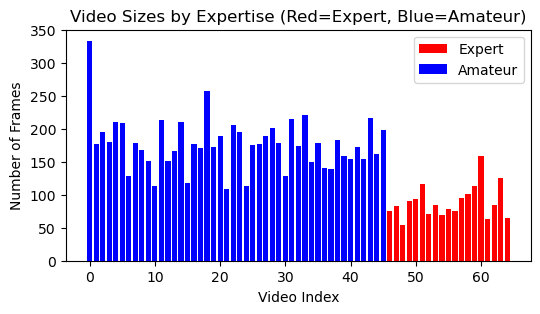

In [5]:
# Extract data for plotting
names = []
sizes = []
colors = []

print("Processing videos...")
for video in videos:
    names.append(video.name)
    sizes.append(video.total_frames)
    if video.label_type == 'amateur':
        colors.append('blue')
    elif video.label_type == 'expert':
        colors.append('red')
    else:
        colors.append('gray') # Fallback for unknown types
        
# Create plot
plt.figure(figsize=(6, 3))
x_pos = np.arange(len(names))
plt.bar(x_pos, sizes, color=colors)

# Add labels and title
plt.xlabel('Video Index')
plt.ylabel('Number of Frames')
plt.title('Video Sizes by Expertise (Red=Expert, Blue=Amateur)')

# Create custom legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='red', label='Expert'),
                    Patch(facecolor='blue', label='Amateur')]
plt.legend(handles=legend_elements)

# Save plot
if not os.path.exists('plots'):
    os.makedirs('plots')

output_path = 'plots/video_sizes.png'
plt.savefig(output_path)

Visualization of shape(height, width) of all videos, color code by amateur/expert

Plotting...
Plot saved to plots/video_shapes.png


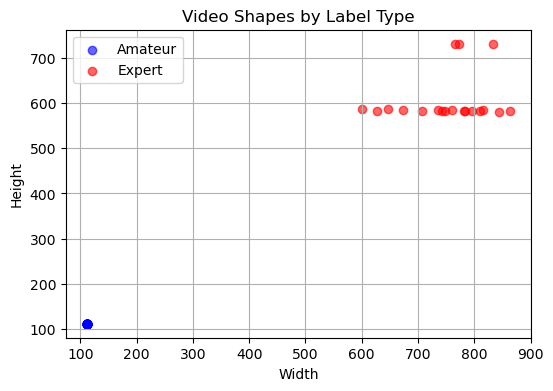

In [6]:
# Extract shapes and labels
shapes = []
labels = []

for video in videos:
    # video.video is (height, width, frames)
    h, w, _ = video.video.shape
    shapes.append((w, h))
    labels.append(video.label_type)

# Plot
print("Plotting...")
plt.figure(figsize=(6, 4))

amateur_shapes = [s for s, l in zip(shapes, labels) if l == 'amateur']
expert_shapes = [s for s, l in zip(shapes, labels) if l == 'expert']

if amateur_shapes:
    aw, ah = zip(*amateur_shapes)
    plt.scatter(aw, ah, c='blue', label='Amateur', alpha=0.6)

if expert_shapes:
    ew, eh = zip(*expert_shapes)
    plt.scatter(ew, eh, c='red', label='Expert', alpha=0.6)

plt.xlabel('Width')
plt.ylabel('Height')
plt.title('Video Shapes by Label Type')
plt.legend()
plt.grid(True)

# Save plot
if not os.path.exists('plots'):
    os.makedirs('plots')
    
plt.savefig('plots/video_shapes.png')
print("Plot saved to plots/video_shapes.png")

All amateur videos are of shape (128, 128, frames)
Expert videos come in various shapes...

All pixel values are in range [0, 255]

## Test video preprocessing

Found 46 amateur videos and 19 expert videos.
Processing Amateur video: T2LZGPQNQI
Saved Amateur comparison plot to plots/amateur_preprocessing_comparison.png
Processing Expert video: TFDB2R0ZSA
Saved Expert comparison plot to plots/expert_preprocessing_comparison.png


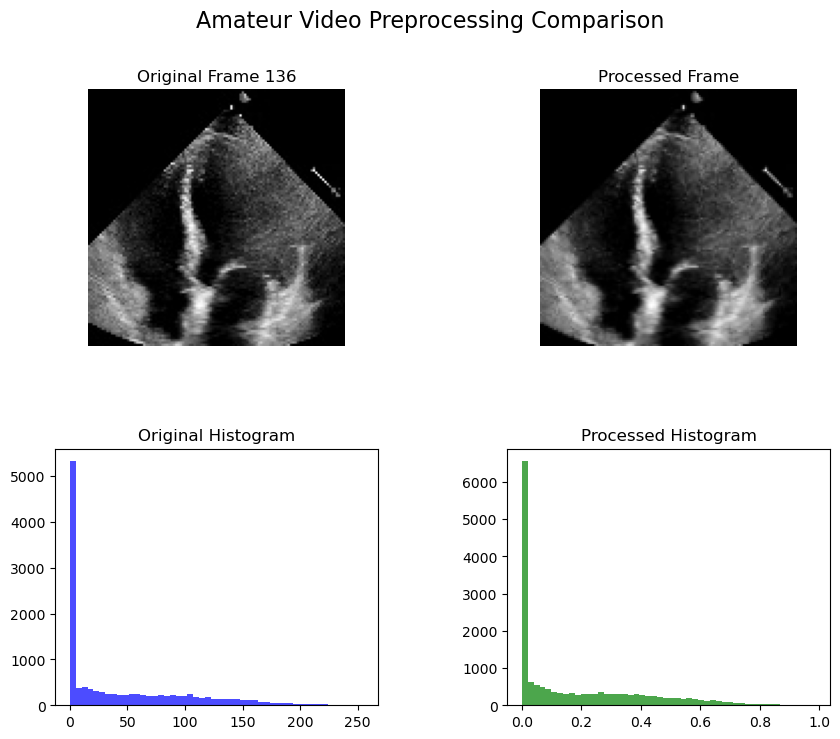

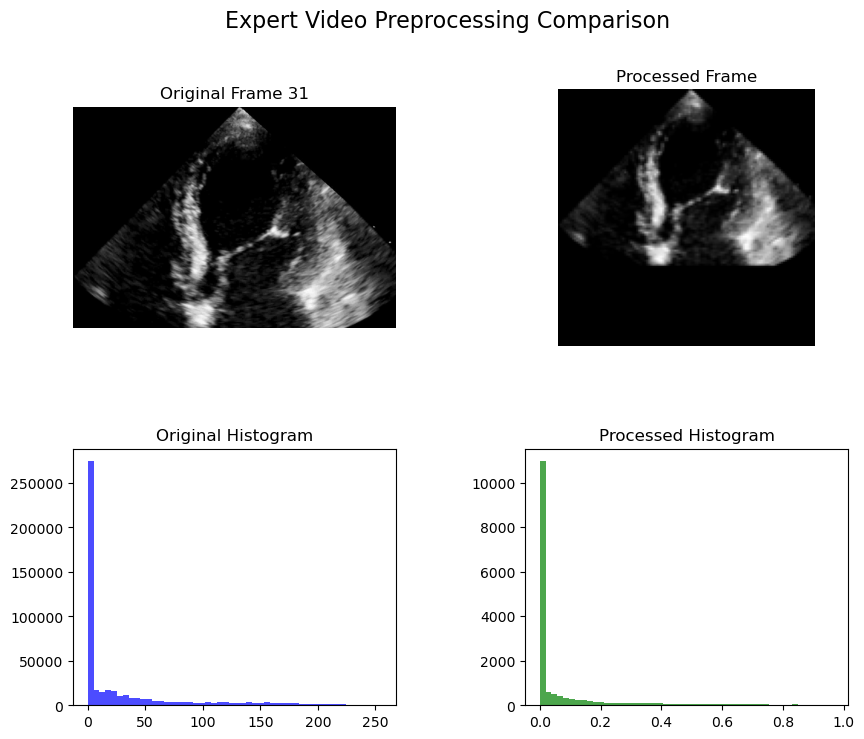

In [ ]:
def test_preprocessing():
    
    # Identify amateur and expert videos
    amateur_videos = [v for v in videos if v.label_type == 'amateur']
    expert_videos = [v for v in videos if v.label_type == 'expert']
    
    # TODO: plot amateur and expert videos after preprocessing
    
test_preprocessing()

Get a preprocessed video

In [16]:
# Get first video
first_video = videos[0]

# preprocess the video
first_video = first_video.preprocess(size=(128, 128), device='cpu')


def tensor_to_gif(x, path, fps=5):
    # x: (T, C, H, W) grayscale, values in [0,255] or [0,1]
    assert x.dim() == 4
    T, C, H, W = x.shape
    assert C == 1

    # Convert to numpy uint8
    if x.max() <= 1:
        x = x * 255
    x = x.clamp(0,255).byte()

    frames = []
    for t in range(T):
        frame = x[t,0].cpu().numpy()
        frames.append(frame)

    imageio.mimsave(path, frames, fps=fps)

tensor_to_gif(first_video, 'plots/preprocessed_first_video.gif')

Study the brightness and contrast of the videos, this is done in order to understand if the dataset needs to be normalized or scaling suffices

In [ ]:
# TODO: do this or simply normalize or something else

View tensors

In [10]:
# load data
train_data = utils.load_zipped_pickle('data/train.pkl')
test_data = utils.load_zipped_pickle('data/test.pkl')

# preprocess data
train_videos = utils.preprocess_train_data(train_data)
test_videos = utils.preprocess_test_data(test_data)

amatour_dataset = []
expert_dataset = []
for video in train_videos:
    if video.label_type == "amateur":
        amatour_dataset.append(video)
    elif video.label_type == "expert":
        expert_dataset.append(video)

print(f"Amatour dataset size: {len(amatour_dataset)}")
print(f"Expert dataset size: {len(expert_dataset)}")



Video D47OR19ANJ loaded: X shape torch.Size([334, 1, 128, 128]), Y_box shape torch.Size([1, 1, 128, 128]), Y_label shape torch.Size([334, 1, 128, 128])
Video IMNKTJV3OI loaded: X shape torch.Size([177, 1, 128, 128]), Y_box shape torch.Size([1, 1, 128, 128]), Y_label shape torch.Size([177, 1, 128, 128])
Video YSCCEISFRH loaded: X shape torch.Size([195, 1, 128, 128]), Y_box shape torch.Size([1, 1, 128, 128]), Y_label shape torch.Size([195, 1, 128, 128])
Video VI47TJR3OQ loaded: X shape torch.Size([181, 1, 128, 128]), Y_box shape torch.Size([1, 1, 128, 128]), Y_label shape torch.Size([181, 1, 128, 128])
Video 7V9NY3JFPX loaded: X shape torch.Size([211, 1, 128, 128]), Y_box shape torch.Size([1, 1, 128, 128]), Y_label shape torch.Size([211, 1, 128, 128])
Video K3AM1YOI38 loaded: X shape torch.Size([209, 1, 128, 128]), Y_box shape torch.Size([1, 1, 128, 128]), Y_label shape torch.Size([209, 1, 128, 128])
Video BBB0U709D2 loaded: X shape torch.Size([129, 1, 128, 128]), Y_box shape torch.Size(

In [ ]:
# create datasets
amatour_dataset = dataset.FramesDataset(amatour_dataset, target="box", transforms=None)
expert_dataset = dataset.FramesDataset(expert_dataset, target="box", transforms=None)

# # plot tensor viz with x and y
plt.imshow(amatour_dataset[0][0].squeeze(1).permute(1, 2, 0).numpy())
plt.show()
plt.imshow(amatour_dataset[0][1].squeeze(1).permute(1, 2, 0).numpy())
plt.show()

AttributeError: 'tuple' object has no attribute 'x'